# Modified Fuchs Model Dataset Generation V5.0

### Author: Ronak Desai + Jack Felice, Modified from Notebook from Tom Zhang and Joe Smith

# Change Log

### V3.0
- Rebuilt Tom's Code to be more readable
- Separated Laser Energy Calculation from Fuchs Model Calculation
- Rewrote the hot electron temperature to be in terms of the m c^2 (gamma - 1) which is a more clear way of computing it which is still equivalent to what Fuchs wrote in his paper.

### V3.1
- Changed r0 = w sqrt(2 ln(2)) -> w sqrt(2 ln(2))/2 from suggestion from Joe Smith
- Changed focal_distances in Fuchs Test Case (Table 1 Predictions) to zero because the paper quotes the spot size at the focal distance (focal spot), not the focal distance. 
- Similarly, Changed Spot Size from 2e-6 -> 6e-6 / sqrt(2 ln(2)) = 6e-6 * 0.8493218 because the paper quotes the FWHM spot size (w = FWHM/sqrt(2 ln(2)) from https://en.wikipedia.org/wiki/Gaussian_beam) 
- Found out that Fuchs assumes fraction f = 0.5 for all of his points in Table 1 (even though with intensity 3e19, we get f = 0.3106). Because of this, added flag to fuchs_model function called const_f which if set to true will keep f at a constant 0.5.

### V4.0
- Added way for model to account for prepulse effects.
- Changed columns of dataframe to all follow the same naming convention to avoid confusion
### V4.1
- Added Pulse Depletion Length from Decker et. al. Paper
### V4.2
- Modified Pulse Depletion Length with analytical integral
- Fixed Minimum $a_0$ which actually makes one peak less than the other
- Fixed all code to use SI base units.
- Added fuchs_spectrum function to return the Fuchs Model $\frac{dN}{dE}$ to get a proton energy spectrum
- Added a different type of noise with Log-Normal Distribution to avoid issue with negative values at high noise level
### V4.3
- Added actual N count instead of just $\frac{dN}{dE}$ for each bin
### V5.0
- Abandoned campaign 1/2 shenanigans
- Reinstated etching length model in favor of the pump depletion length model because of reduced oversimplification


## Imports and Setting Constants of Notebook

In [2]:
# Imports
from fuchs_model import *
from numpy.random import RandomState

# Fixed Seed for Repeatability
seed = 2

# Tag to Indicate Description of Dataset
tag = 'v5_0_seed-' + str(seed)
# *******************************************************
#  Dataset Parameters
# *******************************************************
num_points = 250000 # Number of Points in Testing Dataset
pct_noise = 30 # Percentage of Noise in Dataset
percentPoints = 100 # Percentage of Points to use from Training Set
testing = False # True if testing, False if training

num_intensities = 50
num_focal_distances = 61
num_target_thicknesses = 10
num_contrasts = 50
num_tFWHMs = 1
num_spot_sizes = 1

if not testing:
    percentPoints = 100
    num_points = num_intensities * num_focal_distances * num_target_thicknesses * num_contrasts * num_tFWHMs * num_spot_sizes
    #endTag = "_train_" + str(percentPoints) + "_campaign_" + str(campaign)

# *******************************************************
spectrum = False
bins_per_MeV = 5 
max_energy_MeV = 5 # MeV
max_energy_J = max_energy_MeV * 1.60218e-13 # Joules

# *******************************************************
train_or_test = 'test' if testing else 'train'
spectrum_or_threeEns = '_spectrum_' if spectrum else '_threeEns_'
endTag = "_" + train_or_test + "_" + str(num_points) + '_noise_' + str(pct_noise) + spectrum_or_threeEns 
tag = tag + endTag




# *******************************************************
#  Adjustable Constants that we tweaked from Fuchs Model*
# *******************************************************
c1=25 # tacc = c1 tFWHM: c1 = 1.3 from Fuchs
c2=0.74 # intensity exponent in hot electron fraction f: c2 = 0.74 from Fuchs
theta=25 # Divergence Angle theta: theta = 25 deg from Fuchs
const_f = False # Don't assume f is fixed at 0.5
np.random.seed(seed)

# Generate Fuchs Data

In [3]:
# Everything is in Base SI Units (kg, m, s)
# Changing Intensity, Target Thickness, Focal Distance
# Everything is in Base SI Units (kg, m, s)
# Changing Intensity, Target Thickness, Focal Distance
intensity_min = 1e22 # In W/m^2
intensity_max = 1e23
focal_distance_min = -30.0e-6
focal_distance_max = 30.0e-6
target_thickness_min = 0.5e-6
target_thickness_max = 5.0e-6
# FWHM Period and Spot Size Constant
t_FWHM_min = 40.0e-15
t_FWHM_max = 40.0e-15
spot_size_min = 1.5e-6
spot_size_max = 1.5e-6
contrast_min = 1e-7
contrast_max = 1e-6



if testing:
    # Randomly generate data inputs distributed uniformly in their intervals
    # Vary over all params; no campaign 1 or 2 distinction
    log_intensity_min = 22
    log_intensity_max = 23
    intensities = 10**np.random.uniform(log_intensity_min, log_intensity_max, num_points)
    focal_distances = np.random.uniform(focal_distance_min, focal_distance_max, num_points)
    target_thicknesses = np.random.uniform(target_thickness_min, target_thickness_max, num_points)
    t_FWHMs = np.random.uniform(t_FWHM_min, t_FWHM_max, num_points)
    spot_sizes = np.random.uniform(spot_size_min, spot_size_max, num_points)
    log_contrast_min = -7
    log_contrast_max = -6
    contrasts = 10**np.random.uniform(log_contrast_min, log_contrast_max, num_points)
    ### DO NOT RUN MORE THAN ONCE
else:
    intensity_values = np.linspace(intensity_min, intensity_max, num_intensities)
    focal_distance_values = np.linspace(focal_distance_min, focal_distance_max, num_focal_distances)
    target_thickness_values = np.linspace(target_thickness_min, target_thickness_max, num_target_thicknesses)
    t_FWHM_values = np.linspace(t_FWHM_min, t_FWHM_max, 1)
    spot_size_values = np.linspace(spot_size_min, spot_size_max, 1)
    contrast_values = np.linspace(contrast_min, contrast_max, num_contrasts)
    intensity_grid, focal_distance_grid, thickness_grid, t_FWHM_grid, spot_size_grid, contrast_grid = np.meshgrid(intensity_values, focal_distance_values, target_thickness_values, t_FWHM_values, spot_size_values, contrast_values, indexing='ij')
    intensities = intensity_grid.flatten()
    focal_distances = focal_distance_grid.flatten()
    target_thicknesses = thickness_grid.flatten()
    t_FWHMs = t_FWHM_grid.flatten()
    spot_sizes = spot_size_grid.flatten()
    contrasts = contrast_grid.flatten()

## Fuchs Function: Max, Ave, Total Energy

In [6]:
intensity_values[1] - intensity_values[0]

1.8367346938775507e+21

In [16]:
9/50

0.18

In [3]:
tmp = fuchs_function_with_prepulse(intensities, focal_distances, target_thicknesses,contrast=contrasts,t0=.06e-9, pct_noise=pct_noise, spectrum=False)
noisy_max_proton_energy = tmp[0]
noisy_total_proton_energy = tmp[1]
noisy_average_proton_energy = tmp[2]
efficiency = tmp[3]
laser_energy = tmp[4]
max_proton_energy = tmp[5]
total_proton_energy = tmp[6]
average_proton_energy = tmp[7]

df = pd.DataFrame({'Intensity': intensities, 'Focal Distance': focal_distances, 'Target Thickness': target_thicknesses, 'Contrast': contrasts, 'Max Proton Energy': max_proton_energy, 'Total Proton Energy': total_proton_energy, 'Average Proton Energy': average_proton_energy, 'Noisy Max Proton Energy': noisy_max_proton_energy, 'Noisy Total Proton Energy': noisy_total_proton_energy, 'Noisy Average Proton Energy': noisy_average_proton_energy})

Shape (1525000, 10)


(61, 10)


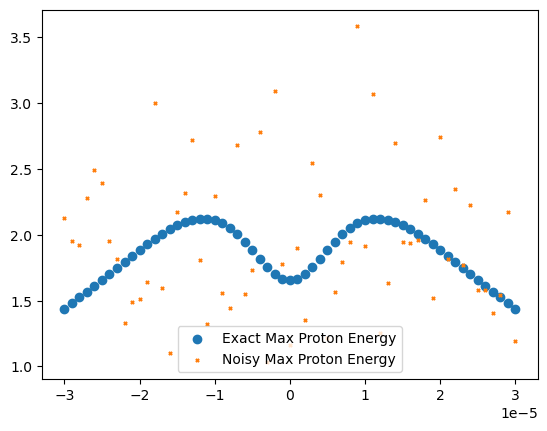

In [4]:
# Vary Focal Distance: Thickness and Intensity Constant
thickness = 0.5e-6
intensity = 1e23
contrast = 1e-7
dx = 0.05e-6
dI = 1e21
dC = 1e-9
subset_df = df[(df["Target Thickness"]>thickness-dx) & (df["Target Thickness"] < thickness+dx) & (df["Intensity"]<intensity+dI) & (df["Intensity"] > intensity-dI) & (df["Contrast"] > contrast - dC) & (df["Contrast"] < contrast + dC)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
print(subset_df.shape)
fig, ax = plt.subplots()
ax.scatter(subset_df["Focal Distance"], subset_df["Max Proton Energy"], label="Exact Max Proton Energy")
ax.scatter(subset_df["Focal Distance"], subset_df["Noisy Max Proton Energy"], s=5, label="Noisy Max Proton Energy", marker='x')
ax.legend(loc='lower center')

In [5]:
subset_df

,Intensity,Focal Distance,Target Thickness,Contrast,Max Proton Energy,Total Proton Energy,Average Proton Energy,Noisy Max Proton Energy,Noisy Total Proton Energy,Noisy Average Proton Energy
1494500,1.000000e+23,-0.000030,5.000000e-07,1.000000e-07,1.438382,1.685175e+09,0.135830,2.127974,2.493085e+09,0.200949
1495000,1.000000e+23,-0.000029,5.000000e-07,1.000000e-07,1.480360,1.730966e+09,0.139049,1.951708,2.282107e+09,0.183322
1495500,1.000000e+23,-0.000028,5.000000e-07,1.000000e-07,1.523318,1.777996e+09,0.142392,1.925071,2.246916e+09,0.179946
1496000,1.000000e+23,-0.000027,5.000000e-07,1.000000e-07,1.567173,1.826231e+09,0.145864,2.277656,2.654159e+09,0.211992
1496500,1.000000e+23,-0.000026,5.000000e-07,1.000000e-07,1.611813,1.875622e+09,0.149472,2.491416,2.899192e+09,0.231042
...,...,...,...,...,...,...,...,...,...,...
1522500,1.000000e+23,0.000026,5.000000e-07,1.000000e-07,1.611813,1.875622e+09,0.149472,1.581892,1.840804e+09,0.146697
1523000,1.000000e+23,0.000027,5.000000e-07,1.000000e-07,1.567173,1.826231e+09,0.145864,1.406954,1.639528e+09,0.130952
1523500,1.000000e+23,0.000028,5.000000e-07,1.000000e-07,1.523318,1.777996e+09,0.142392,1.543853,1.801963e+09,0.144311
1524000,1.000000e+23,0.000029,5.000000e-07,1.000000e-07,1.480360,1.730966e+09,0.139049,2.173690,2.541668e+09,0.204173


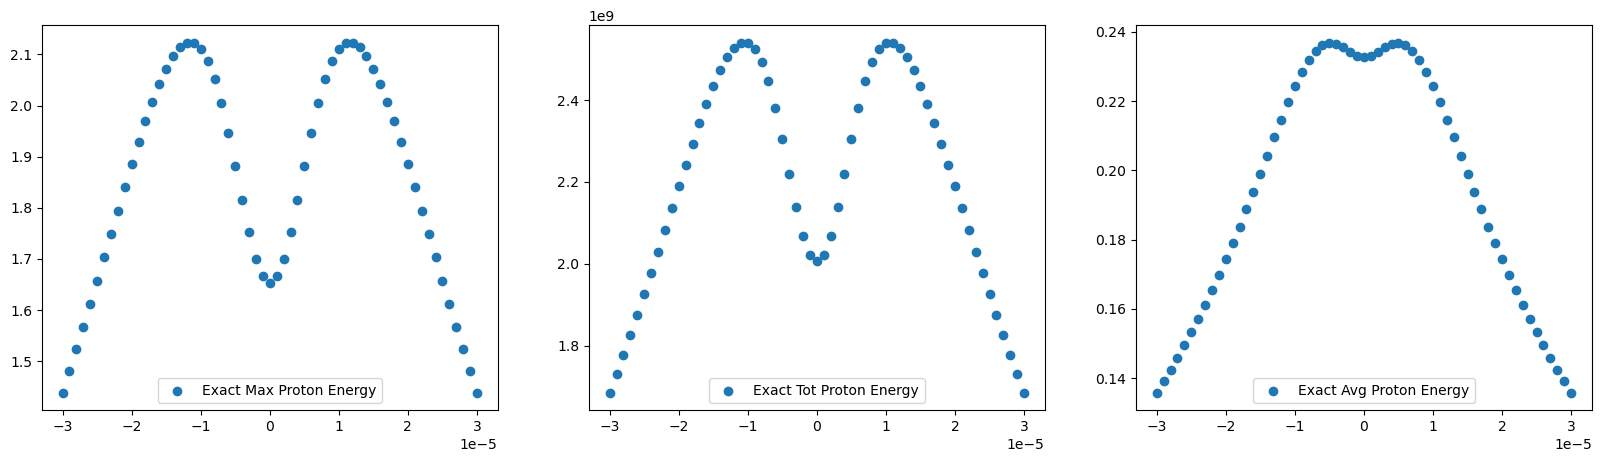

In [6]:
fig2, ax2s = plt.subplots(nrows=1, ncols = 3, figsize=(20,5))
ax2s[0].scatter(subset_df["Focal Distance"], subset_df["Max Proton Energy"], label="Exact Max Proton Energy")
#ax2s[0].scatter(subset_df["Focal Distance"], subset_df["Noisy Max Proton Energy"], s=5, label="Noisy Max Proton Energy", marker='x')
ax2s[0].legend(loc='lower center')
ax2s[1].scatter(subset_df["Focal Distance"], subset_df["Total Proton Energy"], label="Exact Tot Proton Energy")
#ax2s[1].scatter(subset_df["Focal Distance"], subset_df["Noisy Total Proton Energy"], s=5, label="Noisy Tot Proton Energy", marker='x')
ax2s[1].legend(loc='lower center')
ax2s[2].scatter(subset_df["Focal Distance"], subset_df["Average Proton Energy"], label="Exact Avg Proton Energy")
#ax2s[2].scatter(subset_df["Focal Distance"], subset_df["Noisy Average Proton Energy"], s=5, label="Noisy Avg Proton Energy", marker='x')
ax2s[2].legend(loc='lower center')
#ax2.scatter(subset_df["Focal Distance"], subset_df["Noisy Total Proton Energy"], s=5, label="Noisy Tot Proton Energy", marker='x')

# Fuchs Spectrum

In [7]:
if spectrum:
    spectrum_noisy = fuchs_function_with_prepulse(intensities, focal_distances, thicknesses,contrast=contrasts,t0=.06e-9, pct_noise=pct_noise, spectrum=True)
    #spectrum_exact = fuchs_function_with_prepulse(intensities, focal_distances, thicknesses,contrast=contrasts,t0=.1e-9, pct_noise=0, spectrum=True)

In [8]:
if spectrum:
    data_point = np.random.randint(0, num_points)
    print("Viewing Data Point: ", data_point)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    print ('energy bins shape: ', spectrum_noisy[0].shape, 'spectrum shape', spectrum_noisy[1].shape)
    for i in range(2):
        ax[i].set_xlabel('Proton Energy (MeV)')
        ax[i].stairs(spectrum_noisy[4][:, data_point], spectrum_noisy[0], fill=False, color='black', label='exact')
        ax[i].stairs(spectrum_noisy[5][:, data_point], spectrum_noisy[0], fill=True, color='red', alpha=0.5, label='noisy')

    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('Counts per Energy Bin')
    ax[1].set_yscale('log')
    ax[0].set_title('Proton Spectrum Linear Axes')
    ax[1].set_title('Proton Spectrum Log-Linear')


In [9]:
fname = 'datasets/fuchs_' + str(tag)
"""
h5_name = fname + ".h5"

h5f = h5py.File(h5_name, 'w')
h5f.create_dataset('Intensity_(W_cm2)', data= intensities*1e-4) # Convert to W/cm^2
h5f.create_dataset('Pulse_Duration_(fs)', data= time_FWHMs*1e15) # Convert to fs
h5f.create_dataset('Target_Thickness (um)', data= thicknesses*1e6) # Convert to micron
h5f.create_dataset('Spot_Size_(FWHM um)', data=spot_sizes*1e6) # Convert to micron
h5f.create_dataset('Focal_Distance_(um)', data=focal_distances*1e6) # Convert to micron
h5f.create_dataset('Max_Proton_Energy_(MeV)', data= noisy_max_en)
h5f.create_dataset('Total_Proton_Energy_(MeV)', data = noisy_tot_en)
h5f.create_dataset('Avg_Proton_Energy_(MeV)', data = noisy_avg_en)
h5f.create_dataset('Max_Proton_Energy_Exact_(MeV)', data= max_en)
h5f.create_dataset('Total_Proton_Energy_Exact_(MeV)', data = tot_en)
h5f.create_dataset('Avg_Proton_Energy_Exact_(MeV)', data = avg_en)
h5f.create_dataset('laser_E(mJ)', data = laser_en*1e3)
h5f.create_dataset('ratio_proE_laserE_', data = efficiency)

h5f.close()
"""
if spectrum:
    df = pd.DataFrame({'Intensity': intensities*1e-4, 'Pulse Duration': t_FWHMs*1e15, 'Target Thickness': target_thicknesses*1e6, 'Spot Size': spot_sizes*1e6, 'Focal Distance': focal_distances*1e6, 'Contrast': contrasts})
    for i in range(len(spectrum_noisy[5])):
        df['Bin {}'.format(i)] = spectrum_noisy[5][i]
else:
    df = pd.DataFrame({'Intensity': intensities*1e-4, 'Pulse Duration': t_FWHMs*1e15, 'Target Thickness': target_thicknesses*1e6, 'Spot Size': spot_sizes*1e6, 'Focal Distance': focal_distances*1e6, 'Contrast': contrasts, 'Max Proton Energy': noisy_max_proton_energy,
                'Total Proton Energy': noisy_total_proton_energy, 'Avg Proton Energy': noisy_average_proton_energy, 'Max Exact Energy': max_proton_energy, 'Total Exact Energy': total_proton_energy, 'Avg Exact Energy': average_proton_energy, 'Laser Energy': laser_energy * 1e3, 'Conversion Efficiency': efficiency})
#df.to_csv(fname + '.csv', index=False)
#df.to_hdf(fname + '.h5', key='df', mode='w', index=False)

In [10]:
df.sample(frac=1)

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
63666,1.367347e+18,40.0,2.0,1.5,-25.0,3.938776e-07,0.103475,8.507123e+06,0.022409,0.116495,9.577525e+06,0.025229,1.769603,8.670416e-04
1086686,7.428571e+18,40.0,2.0,1.5,8.0,7.612245e-07,0.056534,5.147349e+06,0.016418,0.041249,3.755671e+06,0.011979,4.101354,1.466975e-04
390383,3.204082e+18,40.0,4.0,1.5,18.0,7.061224e-07,0.089694,1.142018e+07,0.021786,0.105576,1.344229e+07,0.025644,3.491662,6.167421e-04
1189418,7.979592e+18,40.0,4.5,1.5,30.0,4.306122e-07,0.303012,1.190669e+08,0.061830,0.237771,9.343082e+07,0.048518,9.238284,1.620173e-03
647695,4.857143e+18,40.0,2.0,1.5,-16.0,9.265306e-07,0.132432,2.273356e+07,0.032475,0.121885,2.092314e+07,0.029889,4.431976,7.562964e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961799,6.693878e+18,40.0,3.0,1.5,2.0,1.000000e-06,0.001046,1.399309e+03,0.000343,0.000702,9.398230e+02,0.000230,1.207091,1.247293e-07
1133010,7.795918e+18,40.0,0.5,1.5,-21.0,2.836735e-07,0.759496,5.117357e+08,0.103890,0.858214,5.782504e+08,0.117393,8.823608,1.049862e-02
1486358,9.816327e+18,40.0,4.0,1.5,14.0,2.469388e-07,0.600352,4.041721e+08,0.113554,0.505332,3.402022e+08,0.095581,9.890552,5.510349e-03
203245,2.102041e+18,40.0,2.5,1.5,10.0,9.265306e-07,0.055457,3.910761e+06,0.014593,0.069892,4.928694e+06,0.018392,2.022289,3.904371e-04


In [11]:
df.sort_values(by='Max Exact Energy', ascending=True)

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
1265999,8.530612e+18,40.0,5.0,1.5,-3.388132e-15,1.000000e-06,0.000091,9.092316e-05,0.000091,3.032168e-19,0.000000e+00,0.000000,0.000012,0.000000
1265499,8.530612e+18,40.0,5.0,1.5,-1.000000e+00,1.000000e-06,0.000092,9.201080e-05,0.000092,3.047301e-19,0.000000e+00,0.000000,0.000012,0.000000
1266499,8.530612e+18,40.0,5.0,1.5,1.000000e+00,1.000000e-06,0.000090,8.982260e-05,0.000090,3.047301e-19,0.000000e+00,0.000000,0.000012,0.000000
1296499,8.714286e+18,40.0,5.0,1.5,-3.388132e-15,1.000000e-06,0.000115,1.149047e-04,0.000115,3.067610e-19,0.000000e+00,0.000000,0.000012,0.000000
1295999,8.714286e+18,40.0,5.0,1.5,-1.000000e+00,1.000000e-06,0.000060,5.980830e-05,0.000060,3.083041e-19,0.000000e+00,0.000000,0.000012,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516000,1.000000e+19,40.0,0.5,1.5,1.300000e+01,1.000000e-07,1.632993,1.934425e+09,0.161800,2.114150e+00,2.504398e+09,0.209473,11.389629,0.035225
1515000,1.000000e+19,40.0,0.5,1.5,1.100000e+01,1.000000e-07,3.068372,3.672570e+09,0.317428,2.122441e+00,2.540375e+09,0.219570,11.076256,0.036742
1504000,1.000000e+19,40.0,0.5,1.5,-1.100000e+01,1.000000e-07,1.319026,1.578758e+09,0.136455,2.122441e+00,2.540375e+09,0.219570,11.076256,0.036742
1503500,1.000000e+19,40.0,0.5,1.5,-1.200000e+01,1.000000e-07,1.809027,2.153714e+09,0.182865,2.123137e+00,2.527674e+09,0.214616,11.239098,0.036029


In [12]:
df[df["Contrast"] == 1e-6].sort_values(by='Max Exact Energy', ascending=True)

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
1265999,8.530612e+18,40.0,5.0,1.5,-3.388132e-15,0.000001,0.000091,9.092316e-05,0.000091,3.032168e-19,0.000000e+00,0.000000,0.000012,0.000000
1265499,8.530612e+18,40.0,5.0,1.5,-1.000000e+00,0.000001,0.000092,9.201080e-05,0.000092,3.047301e-19,0.000000e+00,0.000000,0.000012,0.000000
1266499,8.530612e+18,40.0,5.0,1.5,1.000000e+00,0.000001,0.000090,8.982260e-05,0.000090,3.047301e-19,0.000000e+00,0.000000,0.000012,0.000000
1296499,8.714286e+18,40.0,5.0,1.5,-3.388132e-15,0.000001,0.000115,1.149047e-04,0.000115,3.067610e-19,0.000000e+00,0.000000,0.000012,0.000000
1295999,8.714286e+18,40.0,5.0,1.5,-1.000000e+00,0.000001,0.000060,5.980830e-05,0.000060,3.083041e-19,0.000000e+00,0.000000,0.000012,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433549,9.632653e+18,40.0,0.5,1.5,-3.000000e+01,0.000001,0.250727,1.086932e+08,0.050587,2.638604e-01,1.143868e+08,0.053237,9.489387,0.001931
1494049,9.816327e+18,40.0,0.5,1.5,3.000000e+01,0.000001,0.217260,9.540949e+07,0.043875,2.646333e-01,1.162134e+08,0.053442,9.630407,0.001933
1464049,9.816327e+18,40.0,0.5,1.5,-3.000000e+01,0.000001,0.171831,7.545949e+07,0.034701,2.646333e-01,1.162134e+08,0.053442,9.630407,0.001933
1524549,1.000000e+19,40.0,0.5,1.5,3.000000e+01,0.000001,0.222544,9.896687e+07,0.044986,2.653478e-01,1.180019e+08,0.053638,9.770312,0.001935
